In [12]:
from joblib import Parallel, delayed
import multiprocessing

In [262]:
import os
import sys
import glob
import pickle
import itertools
import random
import copy

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm

from flowMP import *

random.seed(1234)
%matplotlib inline

In [263]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal


import os
import sys
import glob
import pickle
import itertools
import random


import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm


random.seed(1234)



### SAMPLE MONDRIAN PROCESS ###
def draw_Mondrian(theta_space, budget=5):
    return draw_Mondrian_at_t(theta_space, 0, budget)
    
def draw_Mondrian_at_t(theta_space, t, budget):
    dists = theta_space[:,1] - theta_space[:,0]
    lin_dim = np.sum(dists)
    T = np.random.exponential(scale=1./lin_dim)
    
    if t+T > budget: 
        return (theta_space, None, None)
    
    d = np.argmax(np.random.multinomial(n=1, pvals=dists/lin_dim))
    x = np.random.uniform(low=theta_space[d,0], high=theta_space[d,1])
    
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    M_left = draw_Mondrian_at_t(theta_left, t+T, budget)
    
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_Mondrian_at_t(theta_right, t+T, budget)
    
    return (theta_space, M_left, M_right)

def comp_log_p_sample(theta_space, data):
    if theta_space[1] == None and theta_space[2] == None:
        if data.shape[0] == 0:
            return 0
        else:
            mu = np.mean(data, axis = 0)
            residual = data - mu
            cov = np.dot(residual.T , residual) / data.shape[0] + np.identity(data.shape[1])*0.001
            return np.log(multivariate_normal.pdf(data, mean=mu, cov=cov)).sum()
    
    # find the dimension and location of first cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    
    dim, pos = _, left_rec[_,1]
    idx_left = data[:,dim] < pos
    idx_right = data[:,dim] >= pos
    log_len_left =  np.log(pos - root_rec[dim,0])
    log_len_right = np.log(root_rec[dim,1] - pos)
    return comp_log_p_sample(theta_space[1], data[idx_left]) + comp_log_p_sample(theta_space[2], data[idx_right])    
    
    
####Visualization...

### VISUALIZE 2D MONDRIAN PROCESS ###
def print_partitions(p, trans_level=1., color='k'):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
    
    else:
        print_partitions(p[1], trans_level, color)
        print_partitions(p[2], trans_level, color)
        
        
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(data, samples, trans_level=.05, color='k'):

    plt.figure()
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=5, alpha=.5)

    #print all samples
    for sample in samples:
        print_partitions(sample, trans_level, color)
        
        
def print_tree_at_leaf(mp_tree, table):

    if mp_tree[1] == None and mp_tree[2] == None: 
        print table.shape
        return 1
    
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    d, pos = _, left_rec[_,1]
    
    cut_type = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[d]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[d]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[d]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 1
        table_right = table.loc[idx_table_right]
    
    return print_tree_at_leaf(mp_tree[1], table_left) + print_tree_at_leaf(mp_tree[2], table_right)

### VISUALIZE HIERARCHICAL HISTOGRAMS AND CUTS
# generte tree structures for visualization
def find_cuts(list_of_mp_trees):
    if len(list_of_mp_trees) == 0:
        return None
    mp_tree = list_of_mp_trees[0]
    if mp_tree[1] == None and mp_tree[2] == None: 
        return None
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    d, pos = _, left_rec[_,1]
    
    first_cut = [d]+[mp_tree[1][0][d,1] for mp_tree in list_of_mp_trees]
    
    list_of_left_mp_trees = [mp_tree[1] for mp_tree in list_of_mp_trees]
    list_of_right_mp_trees = [mp_tree[2] for mp_tree in list_of_mp_trees]
    
    return [first_cut, find_cuts(list_of_left_mp_trees),find_cuts(list_of_right_mp_trees)]

def split_data_by_MP(mp_tree, data):
    if mp_tree[1] == None and mp_tree[2] == None:
        return [data,None, None]
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    d, pos = _, left_rec[_,1]    
    
    data_left = data[data[:,d] < pos]
    data_right = data[data[:,d] >= pos]
    
    return [data,split_data_by_MP(mp_tree[1], data_left),split_data_by_MP(mp_tree[2], data_right)]
    
def print_cuts_on_hist(tree_tructured_data, theta_space_cuts, node_pos, table):
    depth = len(node_pos)
    cuts = theta_space_cuts
    data_leaf = tree_tructured_data
    for _ in node_pos:
        _ = int(_)
        data_leaf = data_leaf[_]

    for _ in node_pos:
        _ = int(_)
        cuts = cuts[_]
        if cuts == None:
            print "leaf node"
            return
        
    dim = cuts[0]
    list_pos = cuts[1:]
    
    print data_leaf.shape
    
    # plot histogram    
    n, b, patches = plt.hist(data_leaf[:,dim], bins=100, alpha=0.5, label=table.columns[dim])
    plt.legend(loc='upper right')
    plt.yscale('log')
    
    # plot cuts
    for pos in list_pos:
        plt.plot([pos,pos],[0,n.max()],color='r',linewidth = 5,alpha= 0.5)
    plt.show()
    return


### SAMPLE MONDRIAN PROCESS WITH PRIOR INFORMATION ###
def draw_informed_Mondrian(theta_space, table, budget=5):
    
    # INFORMATIVE PRIORS
    upper_cut = (5., 2.)
    lower_cut = (2., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (2., 2.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut, '': neutral_cut
                  }
    
    cut_history = [1] * theta_space.shape[0]
    
    return draw_informed_Mondrian_at_t(theta_space, table, priors_dict, cut_history)
    

def draw_informed_Mondrian_at_t(theta_space, table, priors_dict, cut_history):    
    
    if sum(cut_history) == 0 or table.shape[0] == 1:
        return (theta_space, None, None)

    
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
                 for d in range(table.shape[1])]
    
    if set([types_str[d] for d in range(table.shape[1]) if cut_history[d] == 1]).issubset({'0','1','-1'}):
        return (theta_space, None, None)

    
    low, medium, high, very_high = 0, 1, 100, 1000
    priority_dict = {'-1': low , '0': low, '1': low, 
                   '-1 0': medium, '0 1': medium,
                   '-1 0 1': high, '-1 1':very_high
    }    
        
    types = np.array([priority_dict[_] for _ in types_str])
    

    dists = (theta_space[:,1] - theta_space[:,0])* types    
    lin_dim = np.sum(dists)
    # draw dimension to cut
    dim_probs = ((dists/lin_dim) * np.array(cut_history)) 
    dim_probs /= np.sum(dim_probs)
    d = np.argmax(np.random.multinomial(n=1, pvals=dim_probs))
    cut_history[d] = 0

    prior_type_str = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))])
    prior_params = priors_dict[prior_type_str]
    
    # make scaled cut
    x = (theta_space[d,1] - theta_space[d,0]) * np.random.beta(prior_params[0], prior_params[1]) + theta_space[d,0]
    
    cut_type = types_str[d]
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[d]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[d]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[d]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 1
        table_right = table.loc[idx_table_right]

    
    # make lower partition
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x
    M_left = draw_informed_Mondrian_at_t(theta_left, table_left, priors_dict, list(cut_history))
    
    # make upper partition
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_informed_Mondrian_at_t(theta_right, table_right, priors_dict,list(cut_history))
    
    return (theta_space, M_left, M_right)

def Mondrian_Gaussian_perturbation(theta_space, old_sample, stepsize):
    """
    Input: 
    theta_space: a rectangle
    old_sample: partioned theta_space of a mondrian process
    stepsize: gaussian std
    """
    if old_sample[1] == None and old_sample[2] == None:
        return (theta_space, None, None)
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(old_sample[0].shape[0]):
        if old_sample[0][_,1] > old_sample[1][0][_,1]:
            break    
    dim, pos = _, old_sample[1][0][_,1]
    # propose position of new cut
    good_propose = False
    while good_propose == False:
        new_pos = pos + np.random.normal(0,(old_sample[0][dim,1] - old_sample[0][dim,0])*stepsize,1)[0]
        if new_pos < theta_space[dim,1] and new_pos > theta_space[dim,0]:
            good_propose = True
    
    theta_left = np.copy(theta_space)
    theta_left[dim,1] = new_pos
    theta_right = np.copy(theta_space)
    theta_right[dim,0] = new_pos
    
    new_M_left= Mondrian_Gaussian_perturbation(theta_left, old_sample[1], stepsize)
    new_M_right = Mondrian_Gaussian_perturbation(theta_right, old_sample[2], stepsize)
    
    return (theta_space, new_M_left, new_M_right)

def comp_log_p_prior(theta_space, table, cut_history):
    """
    This function returns prior probability of a Mondrian process theta_space
    """
    if theta_space[1] == None and theta_space[2] == None:
        return 0
    
    log_prior = 0
    

    # INFORMATIVE PRIORS
    upper_cut = (5., 2.)
    lower_cut = (2., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (2., 2.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut, '': neutral_cut
                  }
    
    
    # find the dimension and location of first cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    dim  = _
    beta_pos =  (left_rec[_,1] - left_rec[dim,0])/(root_rec[dim,1] - root_rec[dim, 0])
    
    prior_params = priors_dict[' '.join([str(int(x)) \
                                         for x in sorted(set(table[table.columns[dim]]))])]

    # compute the log likelihood of the first cut
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
                 for d in range(table.shape[1])]
    
    low_priority, medium_priority, high_priority, very_high_priority = 0, 1, 100, 1000
    priority_dict = {'-1': low_priority , '0': low_priority, '1': low_priority, 
                   '-1 0': medium_priority, '0 1': medium_priority,
                   '-1 0 1': high_priority, '-1 1':very_high_priority
    }    
        
    types = np.array([priority_dict[_] for _ in types_str])
    dists = (root_rec[:,1] - root_rec[:,0])* types    
    lin_dim = np.sum(dists)
    
    # probability of dim
    dim_probs = ((dists/lin_dim) * np.array(cut_history)) 
    dim_probs /= np.sum(dim_probs)
    log_prior  += np.log(dim_probs[dim])
    
    
    # probability of pos
    log_prior += np.log(beta.pdf(beta_pos, prior_params[0], prior_params[1]))
    
    # split the table
    cut_history[dim] = 0
    cut_type = types_str[dim]
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[dim]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[dim]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[dim]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] == 1
        table_right = table.loc[idx_table_right]
        
        
        
    return log_prior + comp_log_p_prior(theta_space[1], table_left, list(cut_history)) \
        + comp_log_p_prior(theta_space[2], table_right, list(cut_history))
    

###Classification...

def classify_cells(data, mp_tree, table, cell_type_name2idx):
    Y = np.array([1]*data.shape[0])
    
    if data.shape[0] == 0:
        return Y
    
    if mp_tree[1] == None and mp_tree[2] == None:
        if table.shape[0] > 1:
#            print "more than one clusters, number of data points:", data.shape[0]
            labels = [cell_type_name2idx[table.index[_]] for _ in range(table.shape[0])]
            return np.array(np.random.choice(labels, data.shape[0],replace = True))
        else:
            return Y * cell_type_name2idx[table.index[0]]
    
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    dim, pos = _, left_rec[_,1]
    
    # find labels that match dim info from table
    idx_table_left = table[table.columns[dim]] != 1
    table_left = table.loc[idx_table_left]

    idx_table_right = table[table.columns[dim]] != -1
    table_right = table.loc[idx_table_right]
    
    # find data INDICIES that go high / low on cut position in dimension dim
    idx_left = data[:,dim]  < pos
    idx_right = data[:,dim]  >= pos
    
    Y[idx_left] = classify_cells(data[idx_left],mp_tree[1],table_left, cell_type_name2idx)
    Y[idx_right] = classify_cells(data[idx_right],mp_tree[2],table_right, cell_type_name2idx)

    return Y

def logP_Mondrian_Gaussian_perturbation(indiv_mp,template_mp,stepsize):
    """
    To-do: truncated Gaussian pdf
    """
    if template_mp[1] == None and template_mp[2] == None:
        return 0
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(template_mp[0].shape[0]):
        if template_mp[0][_,1] > template_mp[1][0][_,1]:
            break
    
    dim = _
    pos_template = template_mp[1][0][dim,1]
    pos_indiv = indiv_mp[1][0][dim, 1]
    
    res = norm(pos_template,(template_mp[0][dim,1] - template_mp[0][dim,0])*stepsize).logpdf(pos_indiv)
    
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[1],template_mp[1],stepsize)
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[2],template_mp[2],stepsize)
    return res


### function for computing joint probability
def joint_logP_Random_Effect(template_mp, indiv_mp_list, data_list, table, stepsize):
    """
    INPUT:
    template_mp: one mondrian process
    indiv_mp_list: a list of mondrian processes
    data_list: a list of cell*marker np array
    table: +1 -1 0 information
    """
    logP = comp_log_p_prior(template_mp, table, [1 for _ in range(table.shape[1])])
    n_sample = len(data_list)
    for _ in range(n_sample):
        logP += logP_Mondrian_Gaussian_perturbation(indiv_mp_list[_], template_mp, stepsize)
        logP += comp_log_p_sample(indiv_mp_list[_], data_list[_])
    return logP


## a mini MCMC run to initialize Mondrian process with data
def init_mp(theta_space, table, data, n_iter,mcmc_gaussin_std):
    # randomly draw a template mondrian process
    sample = draw_informed_Mondrian(theta_space, table)
    log_p_sample = comp_log_p_sample(sample, data) + \
                         comp_log_p_prior(sample, table, [1 for _ in range(table.shape[1])])

    for idx in xrange(n_iter):
        new_sample = Mondrian_Gaussian_perturbation(theta_space,sample, mcmc_gaussin_std)
        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data) + \
                            comp_log_p_prior(new_sample, table, [1 for _ in range(table.shape[1])])

        if new_log_p_sample >=  log_p_sample or \
            np.log(np.random.uniform(low=0, high=1.)) <= new_log_p_sample - log_p_sample:
            sample = new_sample
            log_p_sample = new_log_p_sample
    return sample

def mcmc_condition_on_template(user_id,template_mp,n_mcmc_sample=500,mcmc_gaussin_std=0.1):
    """
    sample: data of a sample, np matrix
    tempalte_mp: a mondrain tree
    chain: index of chain
    """
    
    np.random.seed(123)
    indiv_mp = template_mp
    joint_logP = []
    accepts_indiv_mp_list = []
    
    for idx in xrange(n_mcmc_sample):
        if idx % (n_mcmc_sample / 4) == 0:
            mcmc_gaussin_std  = mcmc_gaussin_std / 5
        
        new_sample = Mondrian_Gaussian_perturbation(theta_space,indiv_mp, mcmc_gaussin_std)

        log_p = joint_logP_Random_Effect(template_mp, \
                [indiv_mp],[data[user_id]], table, random_effect_gaussian_std)
        new_log_p = joint_logP_Random_Effect(template_mp, \
                [new_sample],[data[user_id]], table, random_effect_gaussian_std)


        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            indiv_mp = new_sample
            accepts_indiv_mp_list.append(new_sample)
            joint_logP.append(new_log_p)
                
    print "Drawing Sample %d ..." % (idx + 1)
    print "Accepted proposals of indiv mp, template mp: %d" % len(accepts_indiv_mp_list)
                
    return joint_logP, accepts_indiv_mp_list

def log_MP_X_given_template(id):
    res_H = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (id,accepts_template_mp_H[i][-1]) for i in range(n_mcmc_chain))
    res_SJ = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (id,accepts_template_mp_SJ[i][-1]) for i in range(n_mcmc_chain))
    
    """
    res_H: n_mcmc_chain * 2 * n_accepted_in_chain, 
    res_SJ: n_mcmc_chain * 2 * n_accepted_in_chain, log likelihood
    """
    return res_H,res_SJ

def compute_cell_population(data_subset, burnt_samples, table, cell_type_name2idx):
    "Return a list of length n_cell_types"
    burnt_predictions = [None for i in burnt_samples]
    for i in range(len(burnt_samples)):
        burnt_predictions[i] = classify_cells(data_subset, burnt_samples[i], \
                                              table, cell_type_name2idx)
    votes = np.zeros([data_subset.shape[0], table.shape[0]])
    for Y_predict in burnt_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)
    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    return [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]


def find_first_cut(theta_space):
            
    # find the dimension and location of first cut when there is a cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break    
    dim, pos = _, left_rec[_,1]
    return dim , pos
    

def mp_2_cut_tree(mp):
    """
    INPUT:
        mp: a recursively designed data strucutre that stores the structure of data spaces
    OUTPUT:
        D: tree structured (dimenison of cuts, shared across 2 mp trees), each node is an integer
        C: tree structured (position of cuts), each node is a real value
    """
    if mp[1] == None and mp[2] == None:
        return None, None
    d_0, c_0 = find_first_cut(mp)
    D_left, C_left = mp_2_cut_tree(mp[1])
    D_right, C_right = mp_2_cut_tree(mp[2])
    D = [d_0, D_left, D_right]
    C = [c_0, C_left, C_right]
    return D, C

def cut_tree_2_mp(theta_space, D, C):
    """
    INPUT:
        theta_space: D*2 list of lists
        D: tree structured (dimenison of cuts, shared across 2 mp trees), each node is an integer
        C: tree structured (position of cuts), each node is a real value
    OUTPUT:
        mp: a recursively designed data strucutre that stores the structure of data spaces
    """
    if D == None:
        return [theta_space, None, None]
    
    d = D[0]
    x = C[0]
    
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    mp_left = cut_tree_2_mp(theta_left, D[1], C[1])
    
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    mp_right = cut_tree_2_mp(theta_right, D[2], C[2])
    
    return [theta_space, mp_left, mp_right]

def comp_agv_cuts(list_of_C):
    """
    INPUT:
        list_of_C: a list of C, each C should have the save tree structure
        C: tree structured (position of cuts), each node is a real value
    OUTPUT:
        avg_C: an average C whose cut position at each node is the average of all C in the list
    """
    if list_of_C[0] == None:
        return None
    x_0 = sum([C[0] for C in list_of_C])/len(list_of_C)
    avg_C_left = comp_agv_cuts([C[1] for C in list_of_C])
    avg_C_right = comp_agv_cuts([C[2] for C in list_of_C])
    return [x_0, avg_C_left, avg_C_right]



def LOO(X,Y):
    from sklearn.model_selection import LeaveOneOut
    from sklearn import linear_model
    loo = LeaveOneOut()
    models = []
    X = np.array(X)
    Y = np.array(Y)

    predict_prob = []
    for train, test in loo.split(X,Y):
        train_X = X[train]
        train_Y = Y[train]
        test_X = X[test]
        test_Y = Y[test]
        logreg = linear_model.LogisticRegression(C=1e5)
        logreg.fit(train_X, train_Y)
        test_Y_predict = logreg.predict(test_X)
        models.append(logreg)
        predict_prob.append(logreg.predict_proba(test_X)[0][0])

    print predict_prob
    plt.scatter(range(21),predict_prob,s = 100)
    plt.xlim(0, 21)
    plt.ylim(0, 1)
    groups = ['H%s' % i for i in range(1,6)] + ['SJ%s' % i for i in range(1,17)]
    plt.legend()

    plt.xticks(range(21),groups)
    plt.ylabel('P(healthy)')
    plt.title('P(healthy) Predicted by LOOCV Logistic Regression')
    
    return predict_prob,models

In [264]:
def mcmc_template(chain):
    
    print len(data)
    
    np.random.seed(chain)    
    mcmc_gaussin_std = 0.1
    
    accepts_template_mp_chain = []
    accepts_indiv_mp_lists_chain = [[] for i in range(n_samples)]
    joint_logP_chain = []
    
    ### INITIALIZE template_mp AND indivi_mp_list
    print "Initializing template mondrian process with pooled data"
    template_mp = init_mp(theta_space, table, pooled_data, 100, mcmc_gaussin_std)
    indiv_mp_list = [np.copy(template_mp) for _ in range(n_samples)] 
    accepts_template_mp_chain.append(template_mp)

    for idx in xrange(n_mcmc_sample):
        if idx == n_mcmc_sample / 3:
            mcmc_gaussin_std  = mcmc_gaussin_std / 5
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(template_mp, \
                    [indiv_mp_list[_]],[data[_]], table, random_effect_gaussian_std)
            new_log_p = joint_logP_Random_Effect(template_mp, \
                    [new_sample],[data[_]], table, random_effect_gaussian_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepts_indiv_mp_lists_chain[_].append(new_sample)
                
                
        # update template mondrian process
#         new_sample = Mondrian_Gaussian_perturbation(
#                     theta_space, template_mp, mcmc_gaussin_std)
        D_template = mp_2_cut_tree(template_mp)[0]
        list_of_C = [mp_2_cut_tree(_)[1] for _ in indiv_mp_list]
        C_template = comp_agv_cuts(list_of_C)
        new_sample = cut_tree_2_mp(theta_space, D_template, C_template)
        
        log_p = joint_logP_Random_Effect(template_mp, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)

        new_log_p = joint_logP_Random_Effect(new_sample, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepts_template_mp_chain.append(template_mp)
            
        joint_logP_chain.append(joint_logP_Random_Effect(template_mp, indiv_mp_list, \
                                data, table, random_effect_gaussian_std))

        if (idx + 1) % (n_mcmc_sample/4) == 0:
            print "Chain %d: Drawing Sample %d ..." % (chain, idx + 1)
            print "Accepted proposals of indiv mp, template mp: %d, %d, %d, %d, %d, %d" \
                    % (len(accepts_indiv_mp_lists_chain[0]), \
                       len(accepts_indiv_mp_lists_chain[1]), \
                       len(accepts_indiv_mp_lists_chain[2]), \
                       len(accepts_indiv_mp_lists_chain[3]), \
                       len(accepts_indiv_mp_lists_chain[4]), \
                       len(accepts_template_mp_chain))
                
    return accepts_template_mp_chain,accepts_indiv_mp_lists_chain,joint_logP_chain

## Flow Cytometry Data

Load AML data from 21 samples, 5 of them are healthy (H\*), 16 of them are AML samples (SJ\*).

In [3]:
%%time

# load data into a dictionary of pandas data frames

PATH_DATA = '/extra/disij0/data/flow_cytometry/cytobank/levine_aml/CSV/'
#PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'

user_ids = ['H1','H2','H3','H4','H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
           'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']

data_dict = dict()
for id in user_ids:
    print id
    data_path = PATH_DATA + id
    allFiles = glob.glob(data_path + "/*fcsdim_42.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    data_dict[id] = pd.concat(list_)

H1
H2
H3
H4
H5
SJ01
SJ02
SJ03
SJ04
SJ05
SJ06
SJ07
SJ08
SJ09
SJ10
SJ11
SJ12
SJ13
SJ14
SJ15
SJ16
CPU times: user 2min 30s, sys: 6.62 s, total: 2min 36s
Wall time: 7min 15s


In [4]:
markers = ['HLA-DR','CD19','CD34','CD45','CD47','CD44','CD117','CD123','CD38','CD11b',\
                'CD7','CD15','CD3','CD64','CD33','CD41']
 
print markers
    
PATH_TABLE = '/home/disij/projects/acdc/data/AML_benchmark/'
table = pd.read_csv(PATH_TABLE + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
table = table[markers]
print table.shape
print table

cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
cell_type_idx2name = {i:x for i,x in enumerate(table.index)}

['HLA-DR', 'CD19', 'CD34', 'CD45', 'CD47', 'CD44', 'CD117', 'CD123', 'CD38', 'CD11b', 'CD7', 'CD15', 'CD3', 'CD64', 'CD33', 'CD41']
(14, 16)
                        HLA-DR  CD19  CD34  CD45  CD47  CD44  CD117  CD123  \
Basophils                 -1.0    -1    -1   0.0   0.0   0.0    0.0      1   
CD4 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD8 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16- NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16+ NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123- HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123+ HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0      1   
CD34+CD38lo HSCs           0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
Mature B cells             0.0     1    -1   0.0   0.0   0.0    0.0     -1   
Plasma B cells            -1.0     1    -1   0.0   0.0   0.0    0.0     -1   
P

Now run MCMC to collect posterior samples...

# Random effect model

### Training models for healthy samples

In [5]:
f = lambda x: np.arcsinh((x -1.)/5.)
data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['H1','H2','H3','H4','H5']]

# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [17]:
%%time

n_mcmc_chain = 5
n_mcmc_sample = 300
mcmc_gaussin_std = 0.1
random_effect_gaussian_std = 0.5

pooled_data = np.concatenate(data)

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(mcmc_template)(i) for i in range(n_mcmc_chain))

5
5
5
5
5
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Chain 1: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 2, 2, 2, 4, 4, 63
Chain 4: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 6, 4, 4, 7, 7, 62
Chain 0: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 0, 3, 1, 3, 3, 63
Chain 2: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 4, 5, 2, 0, 5, 75
Chain 3: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 3, 1, 1, 0, 1, 75
Chain 1: Drawing Sample 150 ...
Accepted proposals of indiv mp, template mp: 14, 10, 4, 11, 12, 132
Chain 4: Drawing Sample 150 ...
Accepted proposals of indiv mp, template mp: 18, 12, 9, 14, 15, 126
Chain 0: Drawing Sample 150 ...
Accepted

In [18]:
accepts_template_mp_H = []
accepts_indiv_mp_lists_H = []
joint_logP_H = []

for _ in results:
    accepts_template_mp_H.append(_[0])
    accepts_indiv_mp_lists_H.append(_[1])
    joint_logP_H.append(_[2])

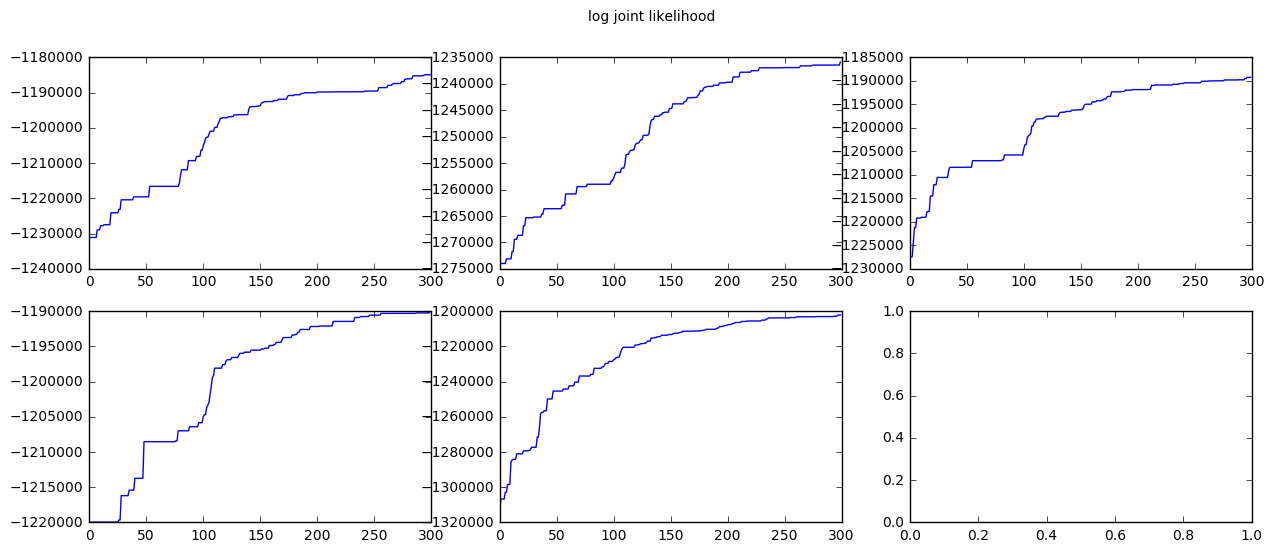

In [19]:
fig, axarr = plt.subplots(n_mcmc_chain / 3 + 1, 3, figsize=(15,6 * 1))
for i in range(n_mcmc_chain):
    axarr[i/3,i%3].plot(joint_logP_H[i])
fig.suptitle("log joint likelihood")
plt.show()

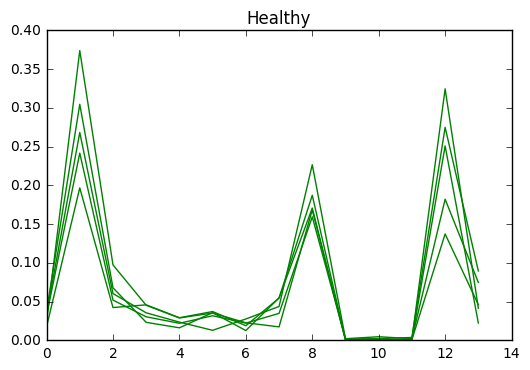

In [20]:
population_size_H = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_H[_][id][-2:]]
    population_size_H[id] = compute_cell_population(data_subset, burnt_samples, \
                                    table, cell_type_name2idx)

for id in range(n_samples):
    plt.plot(population_size_H[id],color = 'g')
plt.title('Healthy')
plt.show()

### Training models for unhealthy samples

In [27]:
data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['SJ01','SJ02',\
            'SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
            'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']]
 
# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [28]:
%%time
pooled_data = np.concatenate(data)
results = Parallel(n_jobs=num_cores)(delayed(mcmc_template)(i) for i in range(n_mcmc_chain))

16
16
16
16
16
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Chain 4: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 3, 8, 2, 4, 4, 75
Chain 2: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 5, 8, 4, 8, 9, 74
Chain 1: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 4, 2, 2, 9, 2, 72
Chain 0: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 3, 6, 9, 5, 7, 74
Chain 3: Drawing Sample 75 ...
Accepted proposals of indiv mp, template mp: 2, 5, 11, 2, 7, 73
Chain 4: Drawing Sample 150 ...
Accepted proposals of indiv mp, template mp: 12, 20, 10, 15, 9, 150
Chain 1: Drawing Sample 150 ...
Accepted proposals of indiv mp, template mp: 9, 16, 10, 22, 9, 145
Chain 2: Drawing Sample 150 ...
Acc

In [29]:
accepts_template_mp_SJ = []
accepts_indiv_mp_lists_SJ = []
joint_logP_SJ = []

for _ in results:
    accepts_template_mp_SJ.append(_[0])
    accepts_indiv_mp_lists_SJ.append(_[1])
    joint_logP_SJ.append(_[2])

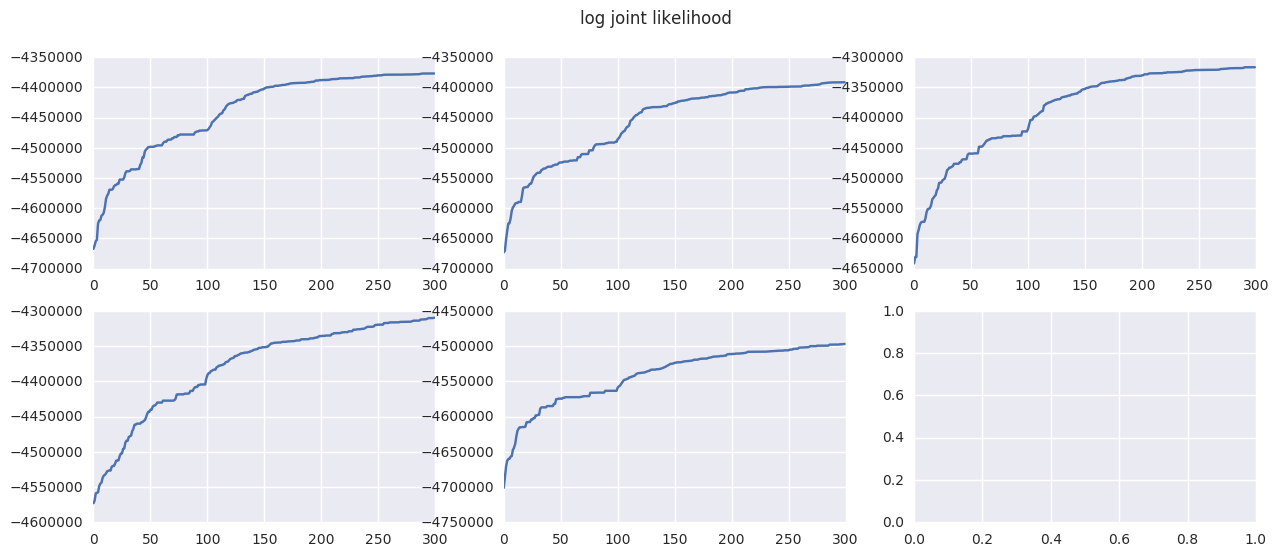

In [30]:
fig, axarr = plt.subplots(n_mcmc_chain / 2, 3, figsize=(15,6 ))
for i in range(n_mcmc_chain):
    axarr[i/3,i%3].plot(joint_logP_SJ[i])
fig.suptitle("log joint likelihood")
plt.show()

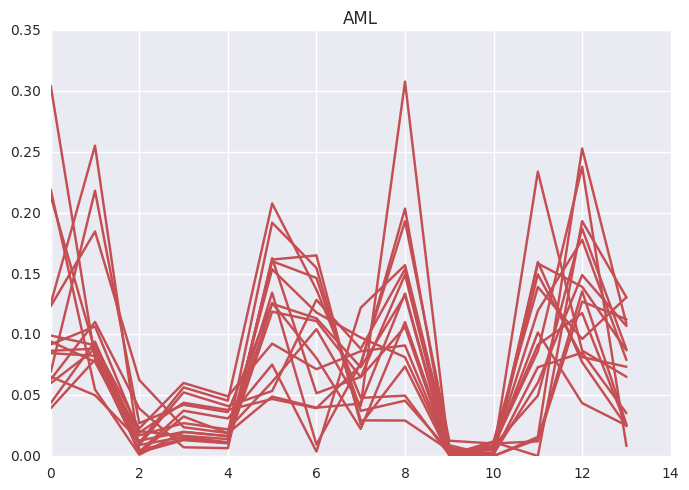

In [31]:
population_size_SJ = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_SJ[_][id][-1:]]
    population_size_SJ[id] = compute_cell_population(data_subset , burnt_samples, \
                                    table, cell_type_name2idx)

for id in range(n_samples):
    plt.plot(population_size_SJ[id],color = 'r')
plt.title('AML')
plt.show()

### compare size of subpopulations in healthy and AML individuals (within sample analysis)

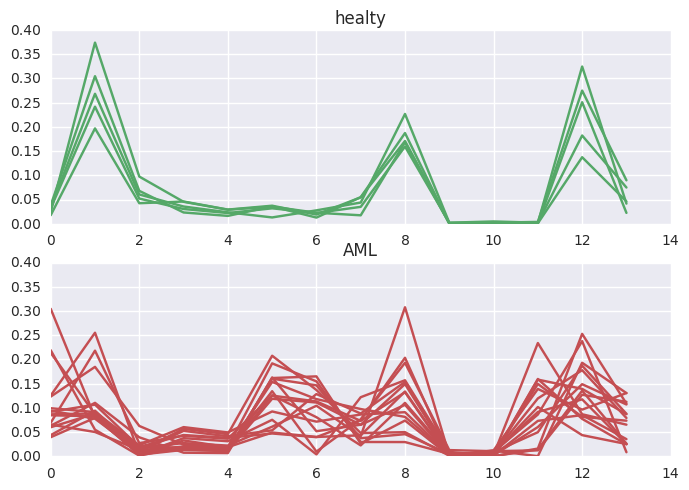

In [38]:
fig, axarr = plt.subplots(2, 1,sharey=True)
for id in range(0,5):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('healty')
for id in range(0,16):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('AML')
plt.show()

[0.98937702535410221, 0.99736582518071348, 0.99565749901464762, 0.99994492732314055, 0.99997683620898592, 2.0880367213038653e-08, 7.5415782090249017e-05, 2.5746813669957902e-07, 1.6639800189954812e-06, 0.056497509438888094, 0.0039620122945280833, 4.3612636955847606e-05, 0.00015474406620186176, 2.2829343915287126e-07, 1.0494301536656536e-06, 8.4663003163676365e-08, 3.254523606166515e-08, 0.00046676322517025248, 4.2186812999389645e-05, 1.8748750663100111e-08, 0.0016370733975059615]


/home/disij/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


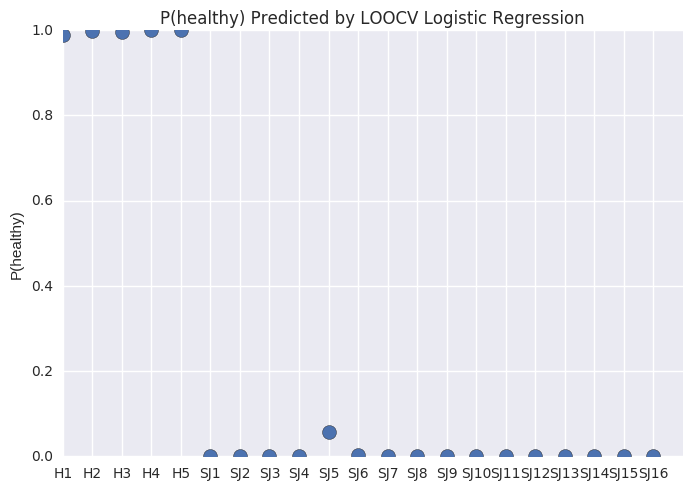

In [39]:
X = np.array(population_size_H  + population_size_SJ)
Y = np.array([0]*5  + [1]*16)
predict_prob,models = LOO(X,Y)

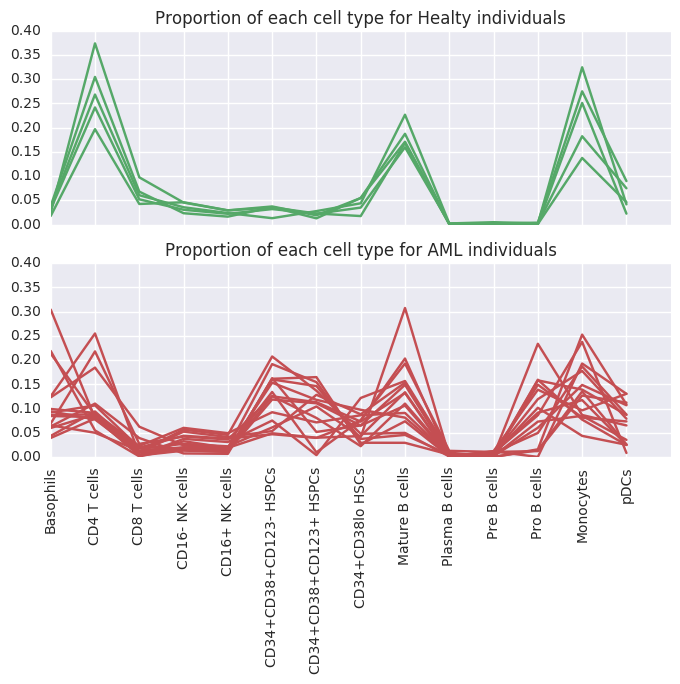

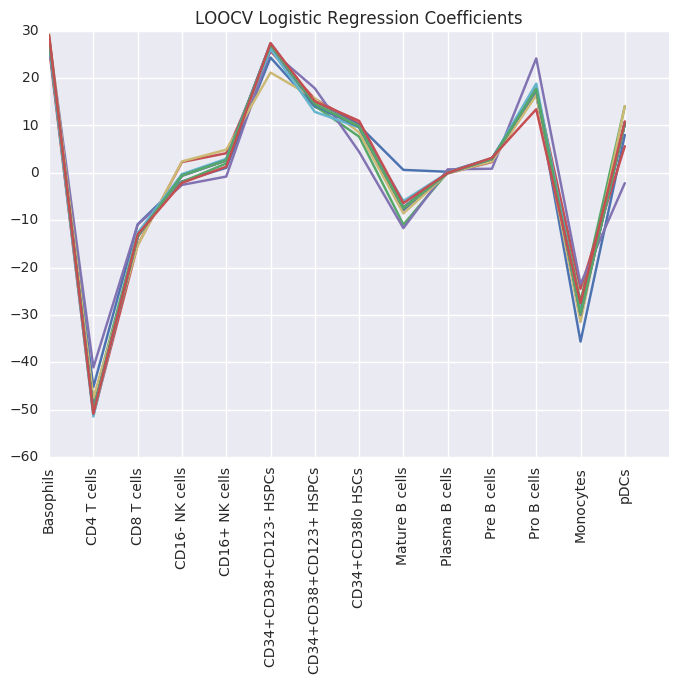

In [40]:
cell_types = [cell_type_idx2name[i] for i in range(14)]

fig, axarr = plt.subplots(2, 1,sharey=True, sharex = True)
for id in range(5):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('Proportion of each cell type for Healty individuals')
for id in range(16):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('Proportion of each cell type for AML individuals')

plt.xticks(range(14),cell_types,rotation = 90)
plt.show()

for i in range(21):
    plt.plot(models[i].coef_[0])
plt.title('LOOCV Logistic Regression Coefficients')
plt.xticks(range(14),cell_types,rotation = 90)
plt.show()

# Diagnosis

In [41]:
# reload data!

data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['H1','H2','H3','H4',\
            'H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
            'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']]
 
# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

### Logistic regression with cell population of under 2 templates as features

In [42]:
%%time

# step 1: learn cell populations of all samples, under 2 template MPs, 5 chains
# V: cell proportion for 21 samples under healthy template
V_H = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]
V_SJ = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]


for id in range(21):
    print id
    res_H = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (id,accepts_template_mp_H[i][-1]) for i in range(n_mcmc_chain))
    indiv_MP_condition_template_H = [_[1][-1] for _ in res_H]
    for chain in range(n_mcmc_chain):
        V_H[id][chain] = compute_cell_population(data[id], indiv_MP_condition_template_H[chain:chain+1], \
                                      table, cell_type_name2idx)
    
    res_SJ = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (id,accepts_template_mp_SJ[i][-1]) for i in range(n_mcmc_chain))
    indiv_MP_condition_template_SJ = [_[1][-1] for _ in res_SJ]
    for chain in range(n_mcmc_chain):
        V_SJ[id][chain] = compute_cell_population(data[id], indiv_MP_condition_template_SJ[chain:chain+1], \
                                      table, cell_type_name2idx)

0
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 35
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 30
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 27
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 27
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 38
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 44
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 56
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 39
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 62
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 66
1
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 32
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 29
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 25
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 27
Dr

In [43]:
X = [[V_H[id][chain] + V_SJ[id][chain] for id in range(21)] for chain in range(n_mcmc_chain)]
Y = [0]*5 + [1]*16

[0.99367990768406478, 0.99965440042944353, 0.92559348952704168, 0.99999899637134371, 0.9862462482061668, 3.3400564680707845e-07, 0.00066841258200878162, 0.00021414519230200657, 2.7573165211847162e-05, 3.4924587604345803e-05, 0.0039543959428109954, 0.00010722151803321811, 7.2129912659701922e-05, 0.011567902211620629, 0.00028670852329493179, 0.0027129425408634056, 1.3857004432793474e-10, 0.0017757489282895778, 6.5283881189870385e-08, 0.0014070519326392361, 0.0010744218375240422]
[0.99347099453402621, 0.99958288560204989, 0.99004805273105267, 0.99997504674892235, 0.9999581437888323, 8.7450290342516723e-09, 2.3592498699098741e-07, 3.5889227145702307e-09, 1.0622357304868046e-07, 0.038989060025777844, 0.00032197242771836443, 1.2864633799347658e-06, 0.011869248859902148, 0.00030118917614441187, 1.6717947947109124e-05, 2.3505465644002577e-05, 8.8007257259548055e-08, 0.061131663178592754, 4.9998425803998714e-05, 3.4789756675590588e-05, 1.6885522131415698e-05]
[0.91445661730922212, 0.99964462427

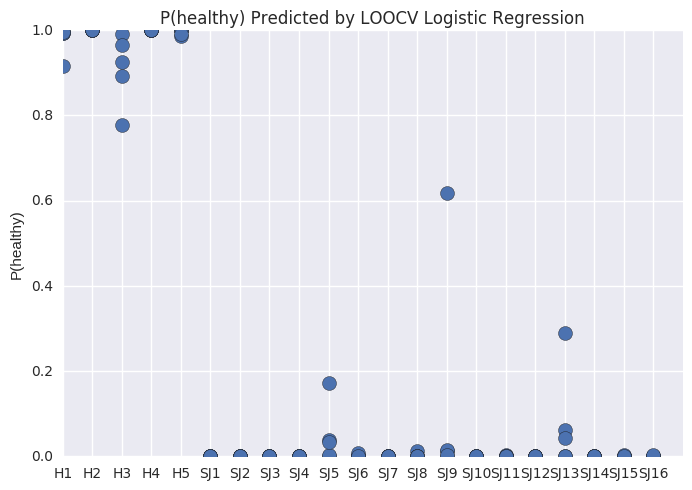

In [61]:
predict_prob,models = [],[]
for chain in range(n_mcmc_chain):
    res = LOO(X[chain],Y)
    predict_prob.append(res[0])
    models.append(res[1])

# Baseline 1: one tree for each group (without random effects) 

In [45]:
# fit 1 tree to pooled healthy samples
global_MP_H = []
global_MP_SJ = []
n_iter = 1000

data_H = np.concatenate(data[0:5])
for chain in range(n_mcmc_chain):
    global_MP_H.append(init_mp(theta_space, table, data_H, n_iter,mcmc_gaussin_std))
    
data_SJ = np.concatenate(data[5:])
for chain in range(n_mcmc_chain):
    global_MP_SJ.append(init_mp(theta_space, table, data_SJ, n_iter,mcmc_gaussin_std))

### Compare classification error(both gives perfect classification): 

In [46]:
V_H_Global = [None for _ in range(21)]
V_SJ_Global = [None for _ in range(21)]


for id in range(21):
    V_H_Global[id] = compute_cell_population(data[id], global_MP_H, table, cell_type_name2idx)
    V_SJ_Global[id] = compute_cell_population(data[id], global_MP_SJ, table, cell_type_name2idx)

X_Global = [V_H_Global[id] + V_SJ_Global[id] for id in range(21)]
Y_Global = [0]*5 + [1]*16

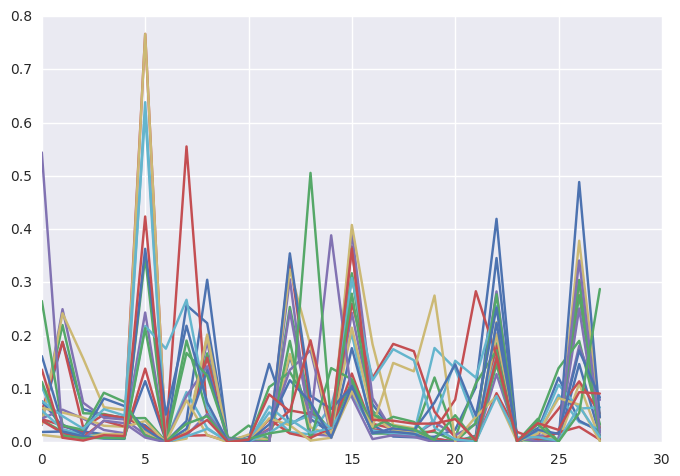

In [47]:
for id in range(21):
    plt.plot(X_Global[id])

[0.98752494988697825, 0.99717384382892116, 0.99609306126839636, 0.99999681121718531, 0.99999926949178297, 3.8639140453877729e-07, 0.0032787835577137159, 3.3172710323103871e-07, 7.6310424251824216e-06, 0.00028150055031295196, 0.13172349524778859, 2.9463118926820187e-06, 2.7724360717740204e-05, 0.00060217488391778318, 1.6819510882948308e-06, 2.7014942910463802e-06, 3.7231293603667837e-09, 0.0057252892794371624, 1.7534327800827754e-07, 1.1414699285783314e-07, 3.4098857665143534e-05]


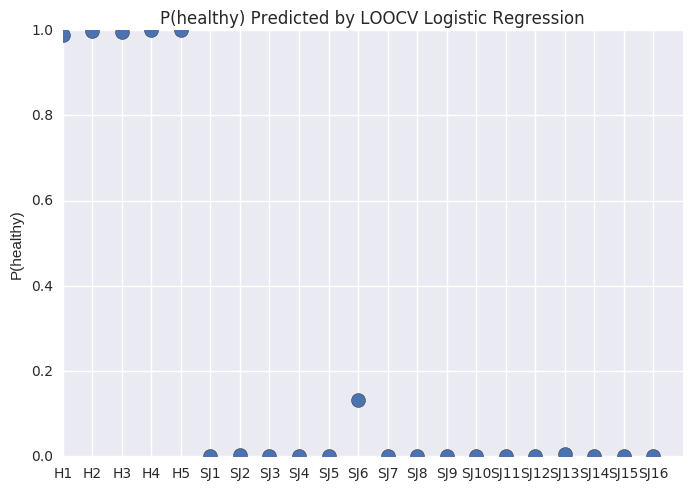

In [59]:
predict_prob_global,models_global = LOO(X_Global,Y_Global)

### Compare log likelihood $P(data_i|MP_i)$

In [49]:
# individual MP with random effects

log_lik_H = [[] for _ in range(5)] # 5 * n_chain
log_lik_SJ = [[] for _ in range(16)] # 5 * n_chain

for id in range(5):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_H[_][id][-1:]]
    for sample in burnt_samples:
        log_lik_H[id].append(comp_log_p_sample(sample, data_subset))

for id in range(16):
    data_subset = data[5+id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_SJ[_][id][-1:]]
    for sample in burnt_samples:
        log_lik_SJ[id].append(comp_log_p_sample(sample, data_subset))

log_lik = log_lik_H + log_lik_SJ 

In [50]:
# individual MP without random effects

log_lik_H_global = [[] for _ in range(5)] # 5 * n_chain * 2
log_lik_SJ_global = [[] for _ in range(16)] # 5 * n_chain * 2

for id in range(5):
    data_subset = data[id]
    for sample in global_MP_H:
        log_lik_H_global[id].append(comp_log_p_sample(sample, data_subset))

for id in range(16):
    data_subset = data[5+id]
    for sample in global_MP_SJ:
        log_lik_SJ_global[id].append(comp_log_p_sample(sample, data_subset))

log_lik_global = log_lik_H_global + log_lik_SJ_global

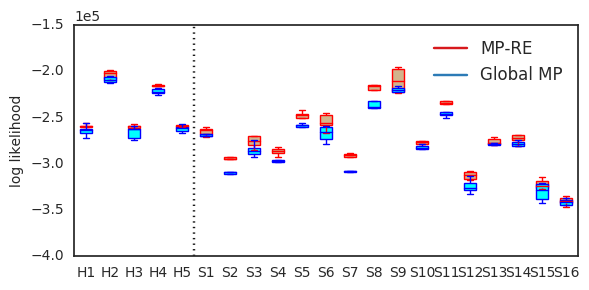

In [298]:
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

fig, ax = plt.subplots(figsize=(6,3))
draw_plot(np.array(log_lik).T, 'red', 'tan')
draw_plot(np.array(log_lik_global).T, 'blue', 'cyan')

ax.set_ylabel('log likelihood',fontsize=10)
#plt.setp(ax.get_yticklabels(),visible=False)

groups = ['H%s' % i for i in range(1,6)] + ['S%s' % i for i in range(1,17)]
plt.plot([], c='#D7191C', label='MP-RE')
plt.plot([], c='#2C7BB6', label='Global MP')
plt.legend(fontsize=12)

plt.plot([5.5, 5.5],[-400000, -150000], c = 'k', linestyle = ':')

plt.xticks(range(1,22),groups)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.xlabel('Subjects')
ax.yaxis.get_major_formatter().set_powerlimits((0,1))
plt.tight_layout()
plt.savefig('log_lik_comparison.png')
plt.show()

# Baseline 2: K means (use centers of pooled healthy data and pooled AML data as feature extractors)

[0.99957763283433509, 0.99885485252270456, 0.98118568140555851, 0.99999054960979017, 0.99997063254704432, 4.3026640457188847e-06, 0.0055757304074162128, 5.0585259043778308e-06, 6.0652879763090084e-07, 0.00019091658833148006, 0.0043653049569929436, 5.7032459874872821e-05, 0.0076303207937618023, 0.98683205070367164, 0.0012310249984547328, 0.023964942080579754, 8.8642442064301719e-07, 1.9553462057841919e-05, 2.1187550134804667e-05, 3.3786011667147342e-05, 2.932361926510918e-05]
[0.99955064613804545, 0.99858666580172484, 0.97770920491571345, 0.99999422407984573, 0.99998291966791519, 3.3537270848205125e-06, 0.0062126532857572636, 6.255274379585174e-06, 6.8856880253154173e-07, 0.00020911720184280114, 0.01326873878003354, 7.0980025453915019e-05, 0.0063022662813789765, 0.99426559271936044, 0.0026655012984032611, 0.041022514620350559, 1.1312533524376889e-06, 1.3805118529996996e-05, 2.3640786669387737e-05, 1.5249168426212378e-05, 1.2343200929132436e-06]
[0.99954686556518046, 0.99856749553186974,

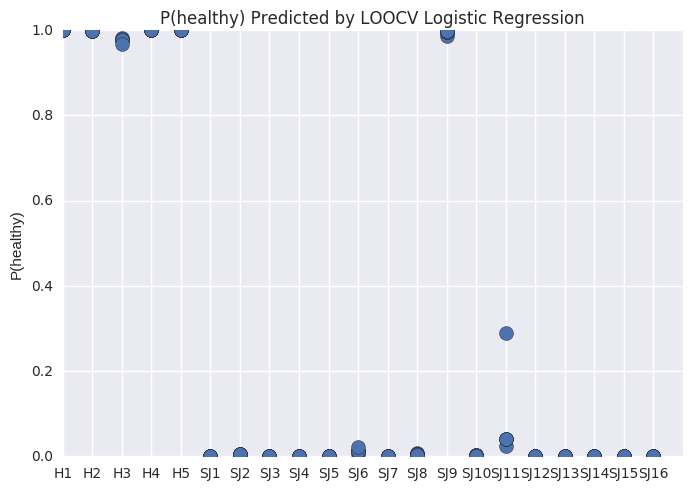

In [54]:
V_Kmeans_H = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]
V_Kmeans_SJ = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]

from sklearn.cluster import KMeans
from scipy.spatial import distance

for chain in range(n_mcmc_chain):
    cluster_centers_H = KMeans(n_clusters=14, random_state=chain).\
                                fit(np.concatenate(data[0:5])).cluster_centers_
    for id in range(21):
        closest_pt_index = distance.cdist(data[id], cluster_centers_H).argmin(axis=1)
        V_Kmeans_H[id][chain] = [sum(closest_pt_index == k)*1.0 / \
                                 len(closest_pt_index) for k in range(14)]        
    cluster_centers_SJ = KMeans(n_clusters=14, random_state=chain).\
                            fit(np.concatenate(data[6:21])).cluster_centers_
    for id in range(21):
        closest_pt_index = distance.cdist(data[id], cluster_centers_SJ).argmin(axis=1)
        V_Kmeans_SJ[id][chain] = [sum(closest_pt_index == k)*1.0 / \
                                 len(closest_pt_index) for k in range(14)] 

X_Kmeans = [[V_Kmeans_H[id][chain] + V_Kmeans_SJ[id][chain] for id in range(21)] \
                    for chain in range(n_mcmc_chain)]

predict_prob_Kmeans,models_Kmeans = [],[]
for chain in range(n_mcmc_chain):
    res = LOO(X_Kmeans[chain],Y)
    predict_prob_Kmeans.append(res[0])
    models_Kmeans.append(res[1])

(21,)


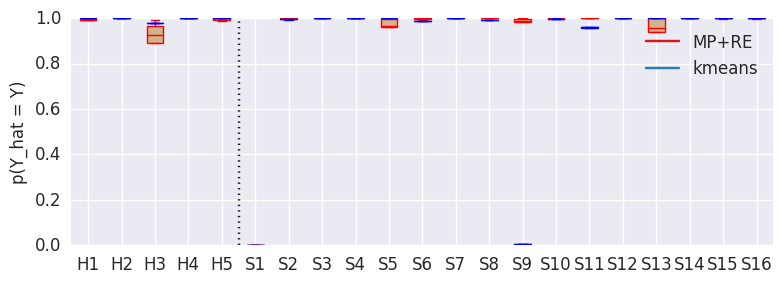

In [62]:
# draw box plot

fig, ax = plt.subplots(figsize=(8,3))
res_1 = np.array(predict_prob)
print res_1[0].shape
res_1[:,6:] = 1 - res_1[:,6:]
res_2 = np.array(predict_prob_Kmeans)
res_2[:,6:] = 1 - res_2[:,6:]
draw_plot(res_1, 'red', 'tan')
draw_plot(res_2, 'blue', 'cyan')

ax.set_ylabel('p(Y_hat = Y)',fontsize=12)
#plt.setp(ax.get_yticklabels(),visible=False)

groups = ['H%s' % i for i in range(1,6)] + ['S%s' % i for i in range(1,17)]
plt.plot([], c='#D7191C', label='MP+RE')
plt.plot([], c='#2C7BB6', label='kmeans')
plt.legend(fontsize=12)

plt.plot([5.5, 5.5],[0,1], c = 'k', linestyle = ':')

plt.xticks(range(1,22),groups)
plt.xticks(fontsize=12)
#plt.xlabel('Subjects')
ax.yaxis.get_major_formatter().set_powerlimits((0,1))
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Random Effect Analysis

In [82]:
def flatten_tree(tree):
    if tree == None:
        return []
    if len(tree) == 1:
        return tree
    else:
        return [tree[0]] + flatten_tree(tree[1]) + flatten_tree(tree[2])
"""
random_effect_H_flattened[patient_id][chain] = a list of unordered offsets
random_effect_SJ_flattened[patient_id][chain] = a list of unordered offsets
"""

    
def compute_diff_mp(template_mp,mp,theta_space):
    """
    Input: 2 mondrian trees
    Output:
        returns mp - tempatlate_mp
        D: tree structured (dimenison of cuts, shared across 2 mp trees), each node is an integer
        C: tree structured (position of cuts), each node is a real value
    """
    if mp[1] == None and mp[2] == None:
        return None, None
    d_0_template, c_0_template = find_first_cut(template_mp)
    d_0_mp, c_0_mp = find_first_cut(mp)
    d_0 = d_0_template
    len_d_0 = theta_space[d_0][1] - theta_space[d_0][0]
    c_0 = (c_0_mp - c_0_template)/len_d_0
    
    D_left, C_left = compute_diff_mp(template_mp[1],mp[1],theta_space)
    D_right, C_right = compute_diff_mp(template_mp[2],mp[2],theta_space)
    D = [d_0, D_left, D_right]
    C = [c_0, C_left, C_right]
    return D, C

In [83]:
random_effect_H = [[None for chain in range(n_mcmc_chain)] for id in range(5)]
random_effect_SJ = [[None for chain in range(n_mcmc_chain)] for id in range(21)]

for id in range(5):
    for chain in range(n_mcmc_chain):
        random_effect_H[id][chain] = compute_diff_mp(accepts_template_mp_H[chain][-1],\
                                                     accepts_indiv_mp_lists_H[chain][id][-1],\
                                                    theta_space)
for id in range(16):
    for chain in range(n_mcmc_chain):
        random_effect_SJ[id][chain] = compute_diff_mp(accepts_template_mp_SJ[chain][-1],\
                                                     accepts_indiv_mp_lists_SJ[chain][id][-1],\
                                                     theta_space)

random_effect_H_flattened = [[flatten_tree(random_effect_H[id][chain][1]) \
                              for chain in range(n_mcmc_chain)] for id in range(5)]
random_effect_SJ_flattened = [[flatten_tree(random_effect_SJ[id][chain][1]) \
                              for chain in range(n_mcmc_chain)] for id in range(16)]

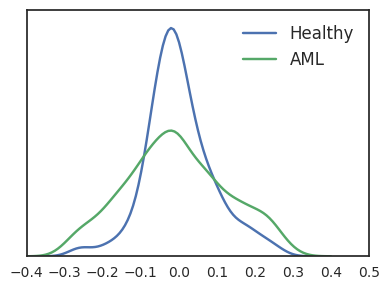

In [312]:
import itertools
import seaborn as sns
sns.set_style("white")
from sklearn.neighbors import KernelDensity

random_effect_H_set = [j for i in random_effect_H_flattened for _ in  i for j in _]
random_effect_SJ_set = [j for i in random_effect_SJ_flattened for _ in  i for j in _]
# bins = 20
# plt.hist(random_effect_H_set,bins = bins)
# plt.show()
# plt.hist(random_effect_SJ_set, bins = bins)
# plt.show()
# kde_H = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(random_effect_H_set)

threshold = 0.3
fig, ax = plt.subplots(figsize=(4,3))
offset_H = sns.distplot([i for i in random_effect_H_set if abs(i) < threshold],label="Healthy",hist=False)
offset_SJ = sns.distplot([i for i in random_effect_SJ_set if abs(i) < threshold], label="AML", hist=False)
# plt.hist(random_effect_H_set,label='healthy',alpha = 0.5)
# plt.hist(random_effect_SJ_set,label='AML',alpha = 0.5)
plt.legend(fontsize = 12)
plt.yticks([])
#plt.xticks([])
plt.savefig('RE_magnitude.png')
plt.tight_layout()
plt.show()

## Visualize random effects(find chains and dimensions what random effects are obvious)

In [297]:
for chain in range(5):
    d,c =  find_first_cut(accepts_template_mp_H[chain][0])
    print d, table.columns[d]
    d,c =  find_first_cut(accepts_template_mp_SJ[chain][0])
    print d, table.columns[d]
    
size = [6,4,3]
print [i*1.0/sum(size) for i in size]

7 CD123
7 CD123
12 CD3
12 CD3
7 CD123
7 CD123
12 CD3
12 CD3
2 CD34
2 CD34
[0.46153846153846156, 0.3076923076923077, 0.23076923076923078]


[1.4786308814322437, 1.5277552308772788, 2.279688683156313]
1.75907845508
0
1
4


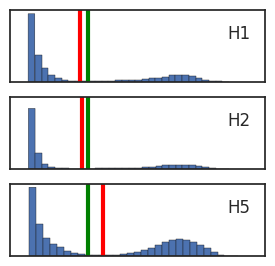

In [322]:
# plot subplots for Heathy group
# choose chain 0, dim CD123 (dimension of first cut)

chain = 3
dim = 12

first_cut_random_effect_H = [random_effect_H[id][chain][1][0] for id in range(5)]

subjects = ['H1','H2','H5']
#subjects = ['H1','H5']
subjects_id = [0,1,4]
fig,axarr = plt.subplots(len(subjects_id),1,figsize=(3,3),sharex=True)
bins = 50

cuts_re =  [find_first_cut(accepts_indiv_mp_lists_H[chain][id][-1])[1] for id in subjects_id]
cuts_template = find_first_cut(accepts_template_mp_H[chain][-1])[1]
print cuts_re
print cuts_template


bar_height = [8000,12000,4900]
for i in range(len(subjects)):
    print subjects_id[i]
    data_1d = data[subjects_id[i]][:,dim]
    axarr[i].plot([cuts_re[i],cuts_re[i]],[0,bar_height[i]], color='red',linewidth=3)
    axarr[i].plot([cuts_template,cuts_template],[0,bar_height[i]], color='green',linewidth=3)
    #sns.distplot(data_1d,ax = axarr[i],kde= False);
    axarr[i].plot([], c='white', label=subjects[i])
    axarr[i].legend(fontsize=12)
    axarr[i].hist(data_1d,bins = 30)
    axarr[i].yaxis.set_visible(False)

# plt.xticks(fontsize=12)
# axarr[i].plot([], c='green', label='Indiv MP')
# axarr[i].plot([], c='red', label='MP+RE')
plt.tight_layout()
plt.xticks([])
plt.savefig('offset_1D.png')